# Setup Environment
### * Choose your favorite directory, say 'mydir'
### * Download dataset https://www.kaggle.com/donorschoose/io/downloads/io.zip/8 and extract to 'mydir/io'

Note for Alec: in the miniconda environment, using the install.packages() function screws up dependencies. (MASS and dplyr occasionally have dependency issues) Its better to just install packages with the conda command line, for example: **conda install -c r r-dplyr**

Resources for Alec: https://conda.io/docs/commands/conda-install.html,
https://conda.io/docs/commands/conda-remove.html,
blog.rtwilson.com/conda-revisions-letting-you-rollback-to-a-previous-version-of-your-environment/
conda install -c r r-essentials
conda install -c r jupyter
conda install -c r r-caret
conda install -c r r-e1071
conda install -c r r-rocr
conda install -c r r-lubridate
conda install -c r r-dplyr
conda install -c r r-broom r-caret r-dbplyr r-dplyr r-essentials r-modelr r-recipes r-tidyr r-tidyverse
conda install -f -c r r-mass

In [2]:
sessionInfo() #Shows the currently loaded and attached packages
library() #Shows the currently available packages, want all below to be available
#install.packages("ggplot2")
#install.packages("ROCR") *
#install.packages("lubridate")
#install.packages("caret")
#install.packages("e1071") *
#install.packages("dplyr")
#install.packages("MASS")

R version 3.4.3 (2017-11-30)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 17134)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RevoUtils_10.0.8     RevoUtilsMath_10.0.1

loaded via a namespace (and not attached):
 [1] compiler_3.4.3  R6_2.2.2        magrittr_1.5    IRdisplay_0.4.4
 [5] pbdZMQ_0.2-6    tools_3.4.3     crayon_1.3.4    uuid_0.1-2     
 [9] stringi_1.1.6   IRkernel_0.8.11 jsonlite_1.5    stringr_1.2.0  
[13] digest_0.6.13   repr_0.12.0     evaluate_0.10.1

In [2]:
library(ggplot2)
library(ROCR)
library(lubridate)
require(caret)
library(e1071)
library(readr)
library(dplyr)

Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: caret
Loading required package: lattice

Attaching package: 'dplyr'

The following objects are masked from 'package:lubridate':

    intersect, setdiff, union

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



# Prepare Data
### * Clean and merge the data Arielle-style. Only needs to be done once.
### * Then save the data for faster loading later.

In [1]:
#Load in Projects and Schools files. Exclude a few columns.
Projects <- read_csv("io/Projects.csv", col_types = cols(`Project Essay` = col_skip(), `Project Need Statement` = col_skip(), `Project Short Description` = col_skip(), `Project Subject Subcategory Tree` = col_skip(), `Project Title` = col_skip()))
Schools <- read_csv("io/Schools.csv")

ERROR: Error in read_csv("io/Projects.csv", col_types = cols(`Project Essay` = col_skip(), : could not find function "read_csv"


In [4]:
#Combine/merge School and Projects data
data <- merge(Projects, Schools, by = "School ID")
names(data) <- c("school.id", "project.id", "teacher.id", "teacher.proj.seq", "project.type", "project.subject", "project.grade", "project.resource", "project.cost", "project.start.date", "project.exp.date", "project.status", "project.funded.date", "school.name", "school.metro.type", "school.percent.lunch", "school.state", "school.zip", "school.city", "school.county", "school.district" )

Parsed with column specification:
cols(
  `School ID` = col_character(),
  `School Name` = col_character(),
  `School Metro Type` = col_character(),
  `School Percentage Free Lunch` = col_integer(),
  `School State` = col_character(),
  `School Zip` = col_character(),
  `School City` = col_character(),
  `School County` = col_character(),
  `School District` = col_character()
)


In [5]:
#Clean the merged data
projectdata <- filter(data, project.status != "Live")
#createdatapartition() look it up

projectdata <- dplyr::filter(data, project.status != "Live")
#projectdata <- lapply(projectdata, gsub, pattern = "unknown", replacement = "uk", fixed = TRUE) #Alec added this
projectdata <- dplyr::filter(projectdata, !is.na(project.status))
projectdata <- dplyr::filter(projectdata, !is.na(project.subject))
projectdata$project.status <- as.factor(projectdata$project.status)
levels(projectdata$project.status)
contrasts(projectdata$project.status)

projectdata <- dplyr::filter(projectdata, !is.na(project.resource))
projectdata <- dplyr::filter(projectdata, !is.na(school.metro.type))
projectdata <- dplyr::filter(projectdata, !is.na(school.percent.lunch))
projectdata <- dplyr::filter(projectdata, !is.na(school.state))

#Rename Project Categories
project_lkup <- c("Applied Learning" = "Applied Learning","Math & Science" = "Math & Science", "History & Civics" = "History & Civics", "Health & Sports" = "Health & Sports", "Special Needs" = "Special Needs", "Literacy & Language" = "Literacy & Language", "Warmth, Care & Hunger" = "Warmth, Care & Hunger", "Music & The Arts" = "Music & The Arts",  "Applied Learning, Literacy & Language" = "Applied Learning", "History & Civics, Math & Science" = "History & Civics", "Literacy & Language, Special Needs" = "Special Needs",
                 "Applied Learning, Special Needs" = "Special Needs", "Health & Sports, Special Needs" = "Special Needs",
                 "Math & Science, Literacy & Language" = "Math & Science", "Literacy & Language, Math & Science" = "Literacy & Language", "Literacy & Language, Music & The Arts" = "Music & The Arts", "Math & Science, Special Needs" = "Special Needs", "Math & Science, Applied Learning" = "Math & Science",
                 "Literacy & Language, Applied Learning" = "Literacy & Language", "Applied Learning, Music & The Arts" = "Music & The Arts", "History & Civics, Literacy & Language" = "History & Civics", "Applied Learning, Math & Science" = "Applied Learning", "Health & Sports, Math & Science" = "Health & Sports", "Applied Learning, Health & Sports" = "Health & Sports", "History & Civics, Music & The Arts" = "History & Civics", "Math & Science, History & Civics" = "Math & Science", "Math & Science, Music & The Arts" = "Music & The Arts", "Special Needs, Music & The Arts" = "Special Needs", "History & Civics, Applied Learning" = "History & Civics", "History & Civics, Special Needs" = "Special Needs", "Music & The Arts, Special Needs" = "Special Needs", "Literacy & Language, Health & Sports" = "Literacy & Language", "Math & Science, Health & Sports" = "Math & Science", "Health & Sports, Literacy & Language" = "Health & Sports", "Applied Learning, History & Civics" = "Applied Learning", "Music & The Arts, History & Civics" = "Music & The Arts", "Health & Sports, Applied Learning" = "Health & Sports", "Music & The Arts, Applied Learning" = "Music & The Arts", "Health & Sports, Music & The Arts" = "Health & Sports", "Special Needs, Health & Sports" = "Special Needs", "History & Civics, Health & Sports" = "History & Civics", "Music & The Arts, Health & Sports" = "Music & The Arts", "Health & Sports, History & Civics" = "Health & Sports", "Health & Sports, Warmth, Care & Hunger" = "Warmth, Care & Hunger", "Special Needs, Warmth, Care & Hunger" = "Special Needs", "Math & Science, Warmth, Care & Hunger" = "Warmth, Care & Hunger", "Applied Learning, Warmth, Care & Hunger" = "Warmth, Care & Hunger",
                 "Literacy & Language, Warmth, Care & Hunger" = "Warmth, Care & Hunger", "History & Civics, Warmth, Care & Hunger" = "Warmth, Care & Hunger",
                 "Music & The Arts, Warmth, Care & Hunger" = "Music & The Arts", "Literacy & Language, History & Civics" = "Literacy & Language")
projectdata$proj.type.clean <- as.character(project_lkup[projectdata$project.subject])

[1] "Expired"      "Fully Funded"

,Fully Funded
Expired,0
Fully Funded,1


In [6]:
projectdata$proj.time.up <- projectdata$project.exp.date - projectdata$project.start.date
projectdata <- dplyr::filter(projectdata, proj.time.up > 6)
projectdata$week.start.date <- as.factor(week(projectdata$project.start.date))
projectdata$year.start.date <- as.factor(year(projectdata$project.start.date))
projectdata <- dplyr::filter(projectdata, school.metro.type != "unknown")

projectdata$week.start.date <- as.factor(projectdata$week.start.date)
projectdata$year.start.date <- as.factor(projectdata$year.start.date)
projectdata$project.status <- make.names(projectdata$project.status)
projectdata$project.status <- as.factor(projectdata$project.status)

In [11]:
#Check the morege, edits, and write outputs for easier loading later.
head(projectdata)
write_csv(projectdata,"io/ArielleMerge.csv")

ERROR: Error in head(projectdata): object 'projectdata' not found


# Perform Cosine Similarity using Arielle's Merged dataset 

### Load data

In [3]:
#Load the data
data <- read_csv("io/ArielleMerge.csv")
dim(data)
length(unique(data$project.id))

Parsed with column specification:
cols(
  .default = col_character(),
  teacher.proj.seq = col_integer(),
  project.cost = col_double(),
  project.start.date = col_date(format = ""),
  project.exp.date = col_date(format = ""),
  project.funded.date = col_date(format = ""),
  school.percent.lunch = col_integer(),
  proj.time.up = col_integer(),
  week.start.date = col_integer(),
  year.start.date = col_integer()
)
See spec(...) for full column specifications.


[1] 976554     25

[1] 976552

### Vectorize and Numeric-ize the Categorical Features
Some features are categories, some are integers. We want these features to be recoded to the "numeric" object type.

Then later, we can choose which features to use for the cosines similarity.

In [8]:
#Work with a new copy of our data for vectorized features
datacode = data

# First, store variables of interest in "factor" object classes (ultimately an integer)
datacode$project.grade <- as.factor(datacode$project.grade)
datacode$school.metro.type <- as.factor(datacode$school.metro.type)
datacode$school.county <- as.factor(datacode$school.county)
#https://stackoverflow.com/questions/9251326/convert-data-frame-column-format-from-character-to-factor

# Second, observe each feature's categorical values so we know what we will encode
# From last step, our data is of the 'factor' class, meaning categorical information is readily available as 'levels'
#https://cran.r-project.org/doc/contrib/de_Jonge+van_der_Loo-Introduction_to_data_cleaning_with_R.pdf
levels(datacode$project.grade)
levels(datacode$school.metro.type)
length(levels(datacode$school.county)) #> 1750 categories. Thats a lot of unique values, lets NOT encode or use it.
#another option is to use unique()
#unique(data[,"project.grade"])
#https://www.quora.com/How-can-I-get-a-count-of-all-unique-values-in-a-Column-in-R-language

# Third, recode our factors. --> FEATURE ENCODING IS SUBJECTIVE <--
#https://dplyr.tidyverse.org/reference/recode.html
lvlkey_g = list('Grades PreK-2' =-2, 'Grades 3-5'=-1, 'unknown'=0, 'Grades 6-8'=1, 'Grades 9-12'=2)
lvlkey_m = list(rural =-2, town =-1, suburban =1, urban =2)
datacode$project.grade = recode(datacode$project.grade, !!!lvlkey_g) #We could as.integer these to save space, but math will be done on them soon as 'numeric' doubles anyways
datacode$school.metro.type = recode(datacode$school.metro.type, !!!lvlkey_m)
#Model Matrix and a 1-hot encoding might also be what we want, but i'm having a hard time using it for desired output: http://appliedpredictivemodeling.com/blog/2013/10/23/the-basics-of-encoding-categorical-data-for-predictive-models
#model.matrix(~ordered(levels(datacode$project.grade)))

# Last, integer data only needs to be numeric-ized, not factorized.
#datacode$project.id = as.numeric(datacode$project.id)
datacode$project.cost = as.numeric(datacode$project.cost)
datacode$school.percent.lunch = as.numeric(datacode$school.percent.lunch)
datacode$teacher.proj.seq = as.numeric(datacode$teacher.proj.seq) #Good
datacode$project.start.date = as.numeric(datacode$project.start.date) #Good

#Check that your features of interest are all 'numeric' type
sapply(datacode,class)

head(datacode)

[1] "Grades 3-5"    "Grades 6-8"    "Grades 9-12"   "Grades PreK-2"
[5] "unknown"

[1] "rural"    "suburban" "town"     "urban"

[1] 1752

school.id           project.id           teacher.id 
         "character"          "character"          "character" 
    teacher.proj.seq         project.type      project.subject 
           "numeric"          "character"          "character" 
       project.grade     project.resource         project.cost 
           "numeric"          "character"            "numeric" 
  project.start.date     project.exp.date       project.status 
           "numeric"               "Date"          "character" 
 project.funded.date          school.name    school.metro.type 
              "Date"          "character"            "numeric" 
school.percent.lunch         school.state           school.zip 
           "numeric"          "character"          "character" 
         school.city        school.county      school.district 
         "character"             "factor"          "character" 
     proj.type.clean         proj.time.up      week.start.date 
         "character"            "integer"            "integer" 
     year.start.date 
           "integer"

school.id,project.id,teacher.id,teacher.proj.seq,project.type,project.subject,project.grade,project.resource,project.cost,project.start.date,...,school.percent.lunch,school.state,school.zip,school.city,school.county,school.district,proj.type.clean,proj.time.up,week.start.date,year.start.date
00003e0fdd601b8ea0a6eb44057b9c5e,1815a6f14dab5590700f5c127fa71448,62df0723ae72ca27cb188e92cbdfdd40,17,Teacher-Led,"Math & Science, Special Needs",1,Supplies,156.31,17376,...,56,West Virginia,26711,Capon Bridge,Hampshire,Hampshire Co School District,Special Needs,123,30,2017
00003e0fdd601b8ea0a6eb44057b9c5e,582bfe05fcd091340103012ac67b9c60,1dc1697372e6e4b6771f911a0d658bab,9,Teacher-Led,"Literacy & Language, Special Needs",1,Books,515.26,17455,...,56,West Virginia,26711,Capon Bridge,Hampshire,Hampshire Co School District,Special Needs,123,42,2017
00003e0fdd601b8ea0a6eb44057b9c5e,8474892544b0eb8fadac379c74e065cf,1dc1697372e6e4b6771f911a0d658bab,10,Teacher-Led,"Math & Science, Special Needs",1,Instructional Technology,214.41,17515,...,56,West Virginia,26711,Capon Bridge,Hampshire,Hampshire Co School District,Special Needs,120,50,2017
00003e0fdd601b8ea0a6eb44057b9c5e,09b528fd601205e99597a91c57ebc8d1,1dc1697372e6e4b6771f911a0d658bab,8,Teacher-Led,"Applied Learning, Special Needs",1,Technology,174.78,17400,...,56,West Virginia,26711,Capon Bridge,Hampshire,Hampshire Co School District,Special Needs,122,34,2017
00003e0fdd601b8ea0a6eb44057b9c5e,edba9de10e797c10cf38780e66fdd03d,21fe8971971fbaca9e39d2013939dc8c,10,Teacher-Led,Math & Science,1,Lab Equipment,252.81,17567,...,56,West Virginia,26711,Capon Bridge,Hampshire,Hampshire Co School District,Math & Science,118,6,2018
00003e0fdd601b8ea0a6eb44057b9c5e,b3f3b7405b865c15cb29b8edb5f8c329,62df0723ae72ca27cb188e92cbdfdd40,10,Teacher-Led,"Math & Science, Special Needs",1,Supplies,396.40,16880,...,56,West Virginia,26711,Capon Bridge,Hampshire,Hampshire Co School District,Special Needs,121,12,2016


# Choose your features and Normalize

In [9]:
X = datacode[,c("project.id","project.grade",'project.cost',"school.metro.type","school.percent.lunch","teacher.proj.seq","project.start.date")]
head(X)
sapply(X,class)
class(X)

#Normalize all columns to range [-1,1]
#There's a function that does this for Machine Learning purposes from the caret package
#https://www.rdocumentation.org/packages/caret/versions/6.0-80/topics/preProcess
#https://stackoverflow.com/questions/44050028/min-max-scaling-normalization-in-r-for-train-and-test-data
pp = preProcess(X, method = "range", rangeBounds = c(-1, 1))
Xn = predict(pp, X)
head(Xn)

### Scratch Work ###

#Test the preProcess function
#test = data.frame(a = 1:6, b = 7:12)
#test
#pp = preProcess(test, method = "range", rangeBounds = c(-1, 1))
#predict(pp, test)

#An alternative is to do it manually with min-max feature scaling
#https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
#https://en.wikipedia.org/wiki/Normalization_(statistics)

#Otherwise the "scale" function might work but I couldn't figure it out
#https://stackoverflow.com/questions/15215457/standardize-data-columns-in-r
#https://www.rdocumentation.org/packages/base/versions/3.5.0/topics/scale

project.id,project.grade,project.cost,school.metro.type,school.percent.lunch,teacher.proj.seq,project.start.date
1815a6f14dab5590700f5c127fa71448,1,156.31,-2,56,17,17376
582bfe05fcd091340103012ac67b9c60,1,515.26,-2,56,9,17455
8474892544b0eb8fadac379c74e065cf,1,214.41,-2,56,10,17515
09b528fd601205e99597a91c57ebc8d1,1,174.78,-2,56,8,17400
edba9de10e797c10cf38780e66fdd03d,1,252.81,-2,56,10,17567
b3f3b7405b865c15cb29b8edb5f8c329,1,396.40,-2,56,10,16880


project.id        project.grade         project.cost 
         "character"            "numeric"            "numeric" 
   school.metro.type school.percent.lunch     teacher.proj.seq 
           "numeric"            "numeric"            "numeric" 
  project.start.date 
           "numeric"

[1] "tbl_df"     "tbl"        "data.frame"

project.id,project.grade,project.cost,school.metro.type,school.percent.lunch,teacher.proj.seq,project.start.date
1815a6f14dab5590700f5c127fa71448,0.5,-0.9990534,-1,0.12,-0.9354839,0.7163412
582bfe05fcd091340103012ac67b9c60,0.5,-0.9962459,-1,0.12,-0.9677419,0.7975334
8474892544b0eb8fadac379c74e065cf,0.5,-0.9985990,-1,0.12,-0.9637097,0.8591984
09b528fd601205e99597a91c57ebc8d1,0.5,-0.9989090,-1,0.12,-0.9717742,0.7410072
edba9de10e797c10cf38780e66fdd03d,0.5,-0.9982986,-1,0.12,-0.9637097,0.9126413
b3f3b7405b865c15cb29b8edb5f8c329,0.5,-0.9971755,-1,0.12,-0.9637097,0.2065776


# Compute Cosine Similarity for Select Rows

### Define functions

In [10]:

### FUNCTIONS ###

#Input: (data frame, row's index, comparison row's index)
#Output: cosine similarity
cosvec = function(X,i,j)
    {
    r1 = as.matrix(X[i,-1]) #Get ith row with all columns -column1
    r2 = as.matrix(X[j,-1])
    return ((r1%*%t(r2)) / (norm(r1, type="2") * norm(r2, type="2"))) #Compute the cosine similarity. t() is transpose. %*% is matrix cross product. norm(x, type = c("O", "I", "F", "M", "2"))
    }


#Input: (data frame, lowest row index, highest row index)
#Output: 'cosine similarity matrix'. It is upper triangular. Containes cosine similarity between all row pairs in the low-high range.
cosim = function(X,lo,hi)
    {
    out = matrix(NA,nrow=(hi-lo)+1,ncol=(hi-lo)+1)
    for (i in lo:hi)
        {
        for (j in i:hi)
            {
            ix = i-lo + 1
            jx = j-lo + 1
            out[ix,jx] = cosvec(X,i,j)#Compare all vectors between lo,hi. Show this in a vector. Only upper triangluar is needed.
            }
        }
    return (out)
    }
#For example, the first row second column out[1,2] shows how element 'lo' is similar to element 'lo+1'
#The following data frame "A" has 4 rows and 4 features. We select to compare rows b->d with lo=b
#
# >> cosim(A,2,4)
#
# >>
#       "A"              "out"
#   f1 f2 f3 f4       b   c   d
#   -----------      ----------
# a| 2 -1  5  2    b| 1  .5   1
# b| 2  3  2  1 -> c| na  1  .5
# c| 1  1  1  1    d| na  na  1
# d| 2  3  2  1

#Input: (data frame, target row index, lowest row index, highest row index)
#Output: 'cosine similarity vector'. Contains the cosine similarity between one target row and all rows in the low-high range.
cosingle = function(X,target,lo,hi)
    {
    out = matrix(NA,nrow=(hi-lo),ncol=1)
    #print(dim(out))
    for (i in lo:hi)
        {
        ix = i-lo
        out[ix,1] = cosvec(X,target,i) #Compare target against all vectors between lo,hi. Show this in a vector.
        }
    return (out)
    }
#For example, the first row shows how out[1,1] shows how element 'target' is similar to element 'lo'
#The following data frame "A" has 4 rows and 4 features. We select target row b to compare against rows c,d lo=c
#
# >> cosingle(A,2,3,4)
#
# >>
#       "A"          "out"
#   f1 f2 f3 f4       
#   -----------      ----
# a| 2 -1  5  2    c| .5 
# b| 2  3  2  1 -> d|  1 
# c| 1  1  1  1    
# d| 2  3  2  1


### Scratch Work ###

#Backup Cosine Similarity
#r1 = as.matrix(X[50,-1]) #Get all columns -column1
#r2 = as.matrix(X[40545,-1])
#cosim = r1%*%t(r2) / (norm(r1, type="2") * norm(r2, type="2"))
#cosim

#Test Triangular Matrix Formula
#a = matrix(c(1,1,1,1,1,1),6,6)
#a
#out = matrix(NA,nrow=(5-2)+1,ncol=(5-2)+1)
#out
#for (i in 2:5)
#    {
#    for (j in i:5)
#        {
#        ix = i-2 + 1
#        jx = j-2 + 1
#        out[ix,jx] = a[i,j]*(i+j)
#        }
#    }
#out

#Code from stack exchange to make the similarity matrix. I couldn't get it to agree with expand.grid
#https://stats.stackexchange.com/questions/31565/is-there-an-r-function-that-will-compute-the-cosine-dissimilarity-matrix
#cos.sim <- function(ix) 
#{
#    A = X[ix[1],]
#    B = X[ix[2],]
#    return( sum(A*B)/sqrt(sum(A^2)*sum(B^2)) )
#}
#n <- nrow(X)/(10^3)
#n
#cmb <- expand.grid(i=1:n, j=1:n) 
#C <- matrix(apply(cmb,1,cos.sim),n,n)

### Visualize a cosine similarity matrix

In [11]:
#Compute Cosine Similarity Matrix
#Alec's computer handles 200 cross-comparisons in 5 minutes
Xheat = cosim(Xn,100,300)

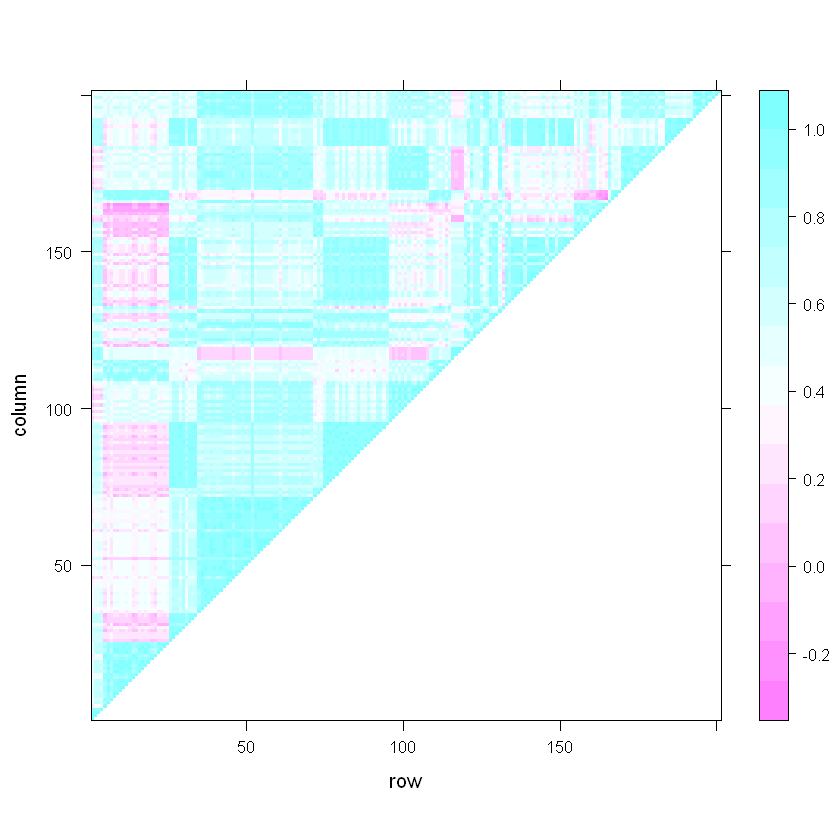

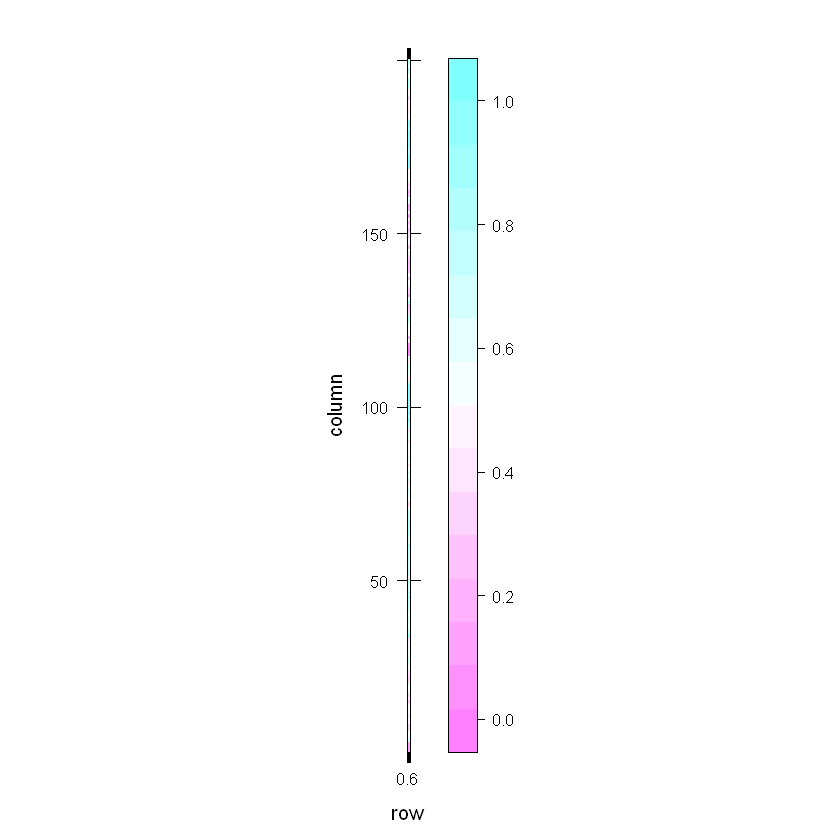

In [12]:
#Visualize the matrix
#https://www.rdocumentation.org/packages/graphics/versions/3.5.0/topics/image
levelplot(Xheat) #Levelplot matrix. It visualizes the cosine similarity matrix

#Compute cosine similarity vector for only the project in row 200
vec200 = cosingle(Xn,200,100,300)
#Visualize the vector
levelplot(t(vec200)) #Levelplot strip. It shows the band from the matrix that is row 100 to the diagonal and up column 100.

### Extract Similar Projects

In [13]:
#Find the indices of top 3 similar projects in our similarity vector
#https://stackoverflow.com/questions/5569038/fastest-way-to-find-the-index-of-the-second-third-highest-lowest-value-in
n = length(unique(vec200))
t1 = which(vec200 == sort(unique(vec200),partial=n-1)[n-1])
t2 = which(vec200 == sort(unique(vec200),partial=n-1)[n-2])
t3 = which(vec200 == sort(unique(vec200),partial=n-1)[n-3])

#Find the corresponding indices in our dataset
xt1 = t1+100 #the 1st index in simvec200 corresponded to the 100th index in Xn
xt2 = t2+100
xt3 = t3+100

#Show those top 3 most similar projects
print("top 3 projects in row 100-300")
head(X[xt1,])
head(X[xt2,])
head(X[xt3,])
print("that are similar to target project in row 200")
head((X[200,]))

#length(single)
#head(sort(single, decreasing=TRUE), 10)
#single[t1]
#single[t2]
#single[t3]

[1] "top 3 projects in row 100-300"


project.id,project.grade,project.cost,school.metro.type,school.percent.lunch,teacher.proj.seq,project.start.date
8e1543957ad6755c9853751ec7e2a2e3,2,427.2,2,95,4,15955


project.id,project.grade,project.cost,school.metro.type,school.percent.lunch,teacher.proj.seq,project.start.date
21f11abb0106d849dfbef0cc78ef5299,2,586.75,2,95,1,15983


project.id,project.grade,project.cost,school.metro.type,school.percent.lunch,teacher.proj.seq,project.start.date
5989ad2acd8d5dba1465341bfac791ba,2,399.4,2,95,1,16025


[1] "that are similar to target project in row 200"


project.id,project.grade,project.cost,school.metro.type,school.percent.lunch,teacher.proj.seq,project.start.date
b289a99d90052f71d543ff80d6b6a737,2,690.56,2,95,2,15920
